<a href="https://colab.research.google.com/github/kollerbud/resume-rec/blob/main/Project_final_report%20with%20recommendations_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from collections import Counter

In [43]:
# Step 1: Load Datasets
# Load Resume Dataset
resume_df = pd.read_csv('Resume.csv')
resume_df = resume_df.rename(columns={'Resume_str': 'Resume'})
resume_df = resume_df.drop_duplicates(subset=['Resume'])  # Remove duplicates
resume_df = resume_df.dropna(subset=['Resume'])  # Drop rows with missing resumes
resume_df = resume_df.drop(columns=['Resume_html'])  # Drop unused column


In [44]:
# Load LinkedIn Job Postings Dataset
job_df = pd.read_csv('postings.csv')

In [45]:
# Load Additional Job and Company Data
job_jobskills = pd.read_csv('job_skills.csv').drop_duplicates(subset="job_id")
job_jobindustries = pd.read_csv('job_industries.csv').drop_duplicates(subset="job_id")
job_specialties = pd.read_csv('company_specialities.csv').drop_duplicates(subset="company_id")
job_industries = pd.read_csv('company_industries.csv').drop_duplicates(subset="company_id")
job_companies = pd.read_csv('companies.csv').drop_duplicates(subset="company_id")
job_skillsmapping = pd.read_csv('skills.csv').drop_duplicates(subset="skill_abr")
job_industrymapping = pd.read_csv('industries.csv').drop_duplicates(subset="industry_id")


In [46]:
# Load Train and Test Data
train_resume = pd.read_csv('train_resume_id.csv')  # Train resume IDs
test_resume = pd.read_csv('test_resume_id.csv')    # Test resume IDs
test_jobs = pd.read_csv('testset_job_id.csv')      # Test job IDs

In [47]:
# Merge Data
temp_df = job_df \
    .merge(job_jobskills, on="job_id", how="left") \
    .merge(job_jobindustries, on="job_id", how="left") \
    .merge(job_specialties, on="company_id", how="left") \
    .merge(job_industries, on="company_id", how="left") \
    .merge(job_companies, on="company_id", how="left") \
    .merge(job_skillsmapping, on="skill_abr", how="left") \
    .merge(job_industrymapping, on="industry_id", how="left")


In [48]:
# Cleaning up temporary columns and renaming
temp_df['zip_code'] = temp_df['zip_code_x'].combine_first(temp_df['zip_code_y'])
temp_df = temp_df.rename(columns={'description_x': 'job_description', 'description_y': 'company_description'})
jobpost_df = temp_df.drop(columns=[
     'company_id', 'applies', 'original_listed_time', 'application_type', 'expiry',
    'closed_time', 'sponsored', 'fips', 'skill_abr', 'industry_id', 'zip_code_x', 'zip_code_y'
])


In [49]:
# Step 2: Combine Relevant Fields
jobpost_df['concat_posting'] = jobpost_df['title'].fillna('') + " " + \
                               jobpost_df['job_description'].fillna('') + " " + \
                               jobpost_df['skills_desc'].fillna('') + " " + \
                               jobpost_df['skill_name'].fillna('') + " " + \
                               jobpost_df['industry_name'].fillna('')


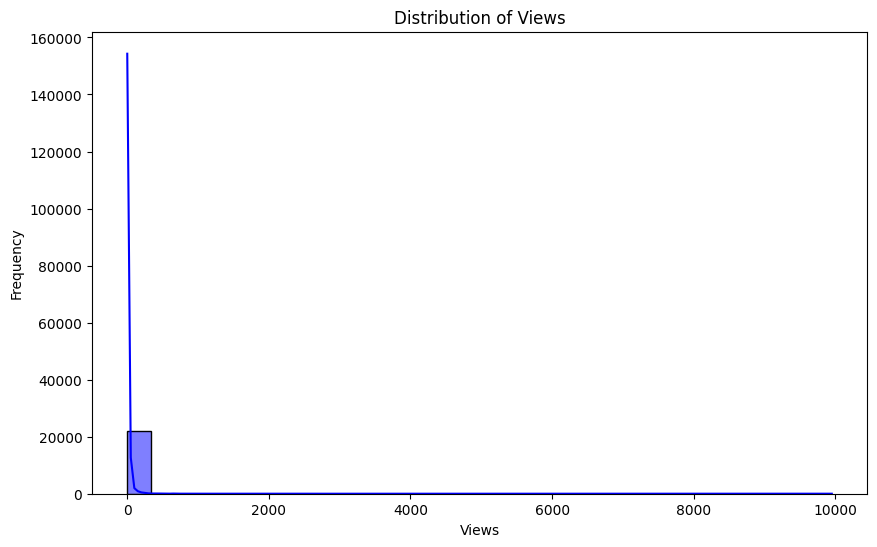

In [50]:
# 2. Distribution of Views

import seaborn as sns # Import the seaborn library
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(jobpost_df['views'], bins=30, kde=True, color="blue")
plt.title("Distribution of Views")
plt.xlabel("Views")
plt.ylabel("Frequency")
plt.show()

<ipython-input-51-4f8f420aecf4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_job_titles.values, y=top_job_titles.index, palette="mako")


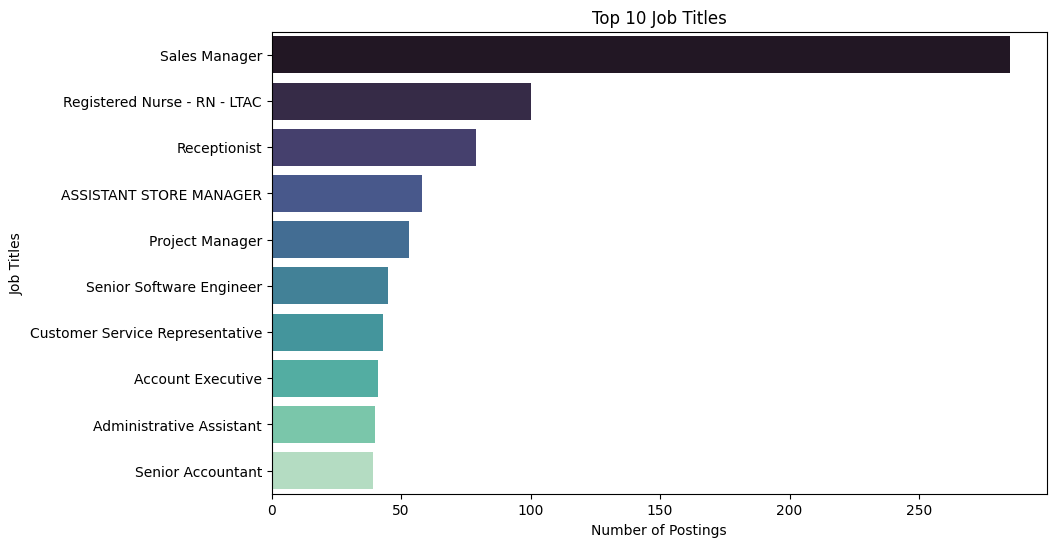

In [51]:
top_job_titles = jobpost_df['title'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_job_titles.values, y=top_job_titles.index, palette="mako")
plt.title("Top 10 Job Titles")
plt.xlabel("Number of Postings")
plt.ylabel("Job Titles")
plt.show()

<ipython-input-52-ccb61305490e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="rocket")


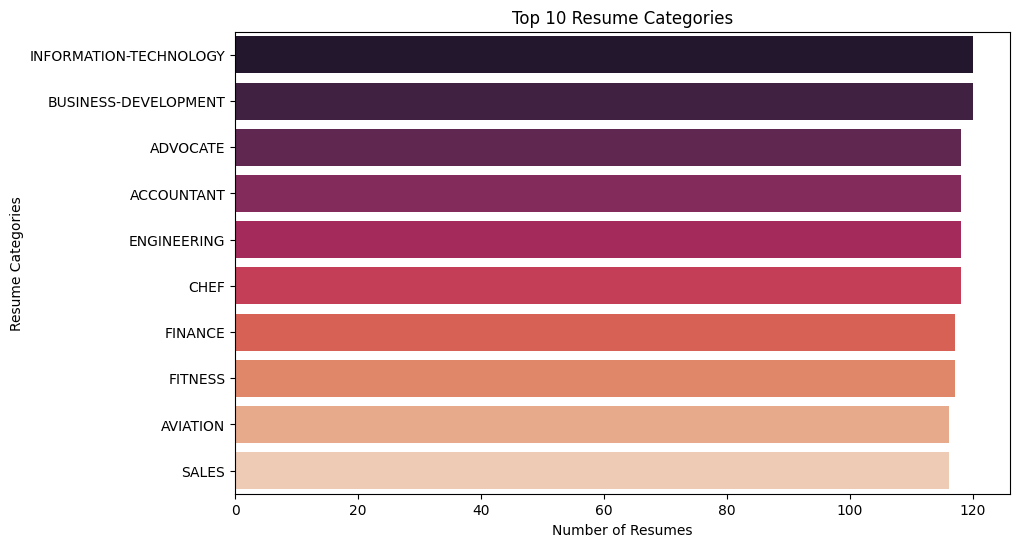

In [52]:
top_categories = resume_df['Category'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette="rocket")
plt.title("Top 10 Resume Categories")
plt.xlabel("Number of Resumes")
plt.ylabel("Resume Categories")
plt.show()

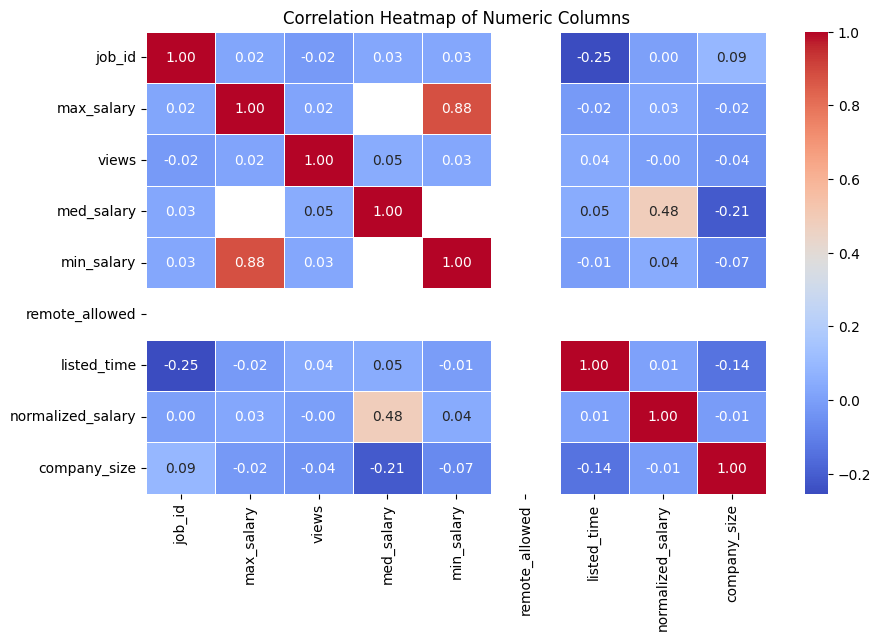

In [53]:
# 5. Correlation Heatmap (for numeric fields)
numeric_columns = jobpost_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Columns")
plt.show()


In [54]:

# Step 3: Clean Text
def clean_text(txt):
    cleanText = re.sub('http\S+\s*', ' ', txt)
    cleanText = re.sub('RT|cc', ' ', cleanText)
    cleanText = re.sub('#\S+', '', cleanText)
    cleanText = re.sub('@\S+', '  ', cleanText)
    cleanText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleanText)
    cleanText = re.sub(r'[^\x00-\x7f]', r' ', cleanText)
    cleanText = re.sub(r'\s+', ' ', cleanText)
    cleanText = re.sub(r'[^\w\s]', '', cleanText)
    cleanText = re.sub(r'[\r\n\t]', ' ', cleanText)
    cleanText = re.sub('ï»¿', '', cleanText)
    return cleanText.strip()

In [55]:
# Apply Cleaning
resume_df['Resume'] = resume_df['Resume'].apply(clean_text)
jobpost_df['concat_posting'] = jobpost_df['concat_posting'].astype(str).apply(clean_text)



In [56]:
print("Columns in jobpost_df:", jobpost_df.columns)



Columns in jobpost_df: Index(['job_id', 'company_name', 'title', 'job_description', 'max_salary',
       'pay_period', 'location', 'views', 'med_salary', 'min_salary',
       'formatted_work_type', 'remote_allowed', 'job_posting_url',
       'application_url', 'formatted_experience_level', 'skills_desc',
       'listed_time', 'posting_domain', 'work_type', 'currency',
       'compensation_type', 'normalized_salary', 'speciality', 'industry',
       'name', 'company_description', 'company_size', 'state', 'country',
       'city', 'address', 'url', 'skill_name', 'industry_name', 'zip_code',
       'concat_posting'],
      dtype='object')


In [57]:
# Step 4: Filter Train and Test Data
train_resumes = resume_df[resume_df['ID'].isin(train_resume['ID'])]
test_resumes = resume_df[resume_df['ID'].isin(test_resume['ID'])]
test_job_postings = jobpost_df[jobpost_df['job_id'].isin(test_jobs['job_id'])]


In [58]:
# Step 4: Tokenization
resume_tokens = resume_df['Resume'].apply(lambda x: x.split())
jobpost_tokens = jobpost_df['concat_posting'].apply(lambda x: x.split())


In [59]:
# Step 5: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
job_tfidf_test = tfidf_vectorizer.fit_transform(test_job_postings['concat_posting'])
test_resume_tfidf = tfidf_vectorizer.transform(test_resumes['Resume'])




In [60]:
# Step 6: Compute Euclidean Distance for Recommendations
euclidean_dist = euclidean_distances(test_resume_tfidf, job_tfidf_test)



In [61]:
# Generate Recommendations
recommendations = []
for i in range(len(test_resumes)):
    similar_jobs = euclidean_dist[i].argsort()[:5]  # Get top 5 closest jobs
    recommendations.append(similar_jobs)



In [62]:
recommendation_df = pd.DataFrame({
    'Resume_Index': range(len(test_resumes)),
    'Recommended_Job_Indices': recommendations
})



In [63]:

# Save Recommendations
recommendation_df.to_csv('recommendations_euclidean.csv', index=False)

In [64]:
# Step 7: Visualization
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()


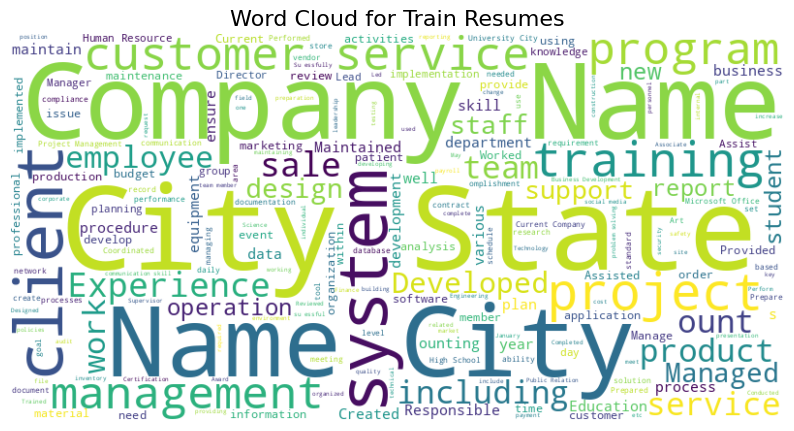

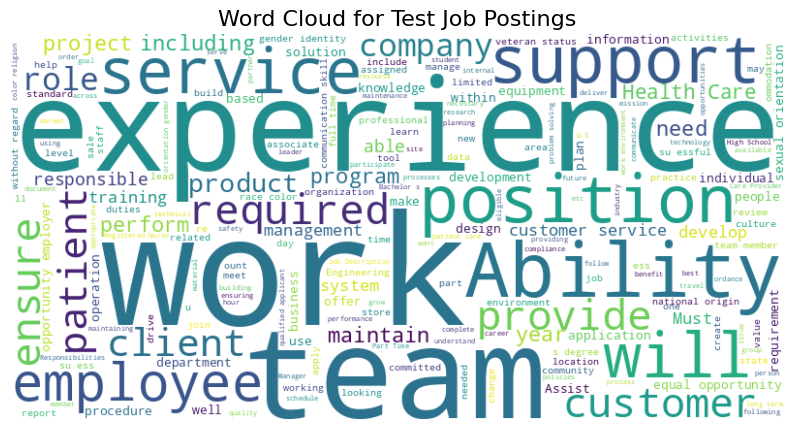

Pipeline completed. Recommendations saved to recommendations_euclidean.csv.


In [65]:
# Word Clouds
plot_wordcloud(train_resumes['Resume'], "Word Cloud for Train Resumes")
plot_wordcloud(test_job_postings['concat_posting'], "Word Cloud for Test Job Postings")

print("Pipeline completed. Recommendations saved to recommendations_euclidean.csv.")

